# Handout #3: Instance-based Learning

## Problem 3

**Given datasets** `dsxx34tr.txt` **and** `dsxx34te.txt`, 
find a suitable SVM classifier adopting a *soft-marging* approach. 
You have to define the classifier design strategy, 
including data normalization, e.g. *min-max* scaling,
and setting up the classifier hyper-parameters, 
e.g. by means of *grid-search*, 
as well as estimate the classifier 
performance by means of *n-fold cross validation*.

### Apartat (3.a)

a) Define the design strategy: input data normalization, 
combinations of hyper-parameters considered 
(kernel and its parameters, and $C$), 
number of folds for the cross-validation process.

**NOTE**: typical values for $C$ are 
$10^{−2}$, $10^{−1}$, $10^0$, $10^1$, $10^2$ and $10^3$.

### Resposta apartat (3.a)

Dades d'identificació:

In [1]:
group = '01' # assuming group 1
ds = 34 # assuming problem 3-4
suffix_tr = 'tr'
suffix_te = 'te'

In [2]:
# Parametritzam algunes propietats de les classes

cl_properties = {
    1: {"target_name": "Classe 1",
        "plot_fmt": "+r",  # red cross
        "hex_color": "#b01010",  # red
        "contrast_fmt": "+w"  # white cross
        },
    -1: {"target_name": "Classe -1", 
        "plot_fmt": "+g",  # green cross
        "hex_color": "#408030",  # green
        "contrast_fmt": "+k"  # black cross
        }
}

cl_properties

{1: {'target_name': 'Classe 1',
  'plot_fmt': '+r',
  'hex_color': '#b01010',
  'contrast_fmt': '+w'},
 -1: {'target_name': 'Classe -1',
  'plot_fmt': '+g',
  'hex_color': '#408030',
  'contrast_fmt': '+k'}}

In [3]:
def get_classes_item_list(item: str) -> list:
    return list(map(lambda k: cl_properties.get(k).get(item), sorted(cl_properties)))

def get_cl_min() -> int:
    return min(cl_properties)

def get_cl_max() -> int:
    return max(cl_properties)

def get_cl_target_name() -> list:
    return get_classes_item_list('target_name')

def get_cl_hex_color() -> list:
    return get_classes_item_list('hex_color')

def get_cl_contrast_fmt() -> list:
    return get_classes_item_list('contrast_fmt')

Importam llibreries

In [4]:
import numpy as np

Carregam dades del problema

In [5]:
# Aquesta funció ens farà més fàcil carregar les matrius

def load_data(group: str, problem: int, sufix: str, 
              convert_zeros: bool = True):
    
    # carregam fitxer del dataset
    data = np.loadtxt('datasets'+group+'/ds'+group+str(ds)+sufix+'.txt')
    # matriu de vectors
    X = data[:, 0:2]
    # vector de classes
    y = data[:, 2:3]
    
    # les classes han de ser -1 i +1
    # per tant si ens ho passen com a 0 i 1 ho transformam
    if convert_zeros and np.any(y == 0):
        y = 2 * y - 1
        
    return X, y

In [40]:
# Carregam 

convert_zeros = (get_cl_min() != 0)

X_train, y_train = load_data(group, ds, suffix_tr, convert_zeros)
y_train = y_train.reshape((-1,))

X_test, y_test = load_data(group, ds, suffix_te, convert_zeros)
y_test = y_test.reshape((-1,))

In [7]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

(240, 2) (240,)
(60, 2) (60,)


In [8]:
# N és el número de vectors

N = X_train.shape[0]
N

240

Definim algunes funcions que ens ajudaran a dibuixar la constel·lació

In [9]:
def get_cl_index(vector: np.ndarray) -> dict: 
    
    if not isinstance(vector, np.ndarray):
        raise ValueError('El paràmetre vector ha de ser de tipus np.ndarray')
        
    d = dict.fromkeys(cl_properties)
    
    for k in d:
        d[k] = list()
        for index, value in enumerate(vector):
            if value == k: 
                d[k].append(index)
    
    return d

In [10]:
import matplotlib.pyplot as plt

def plot_points(X, y):
    
    cl_index = get_cl_index(y)

    ## començam a dibuixar
    ##
    plt.figure(1)

    ## dibuixam els punts per cada classe
    ##
    for k in cl_properties:
        plt.plot(X[cl_index.get(k), 0], X[cl_index.get(k), 1], 
                 cl_properties.get(k).get('plot_fmt'))

    ## format
    ##
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)

    return

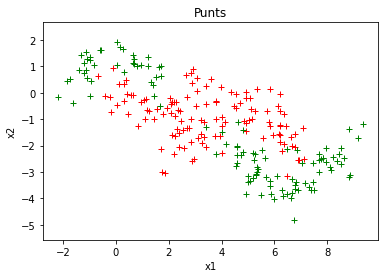

In [11]:
# Vegem quina distribució presenta el conjunt d'entrenament
plot_points(X_train, y_train)

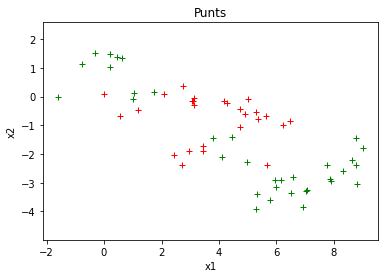

In [12]:
# També representam el conjunt de prova
plot_points(X_test, y_test)

Vaja, sembla que estam davant un **cas de no linealitat**
A més les dades no estan normalitzades.

Per tal de trobar el millor classificador encapsularem dins un *pipe-line* 
els següents processos que detallam:

| Pas | Procés | Eina de `sklearn` |
| :---: | --- | --- |
| 1 | Estandaritzacío dels valors de les característiques a un rang \[0,1\] | classe **`MinMaxScaler`** |
| 2 | Classificació de les mostres | classe **`SVC`** |

Un cop construït aquest *pipe-line*, el farem servir per a processar còmodament 
les dades del conjunt d'interès.
El processat serà una cerca exhaustiva dels millors (hiper)paràmetres utilitzant 
una instància de la classe **GridSearchCV**, aplicant validació creuada. 
Per tal de construïr els subconjunts de validació farem servir un objecte **StratifiedKFold**, 
que ens garantirà que la distribució de mostres de cada classe a cada grup, és uniforme. 

Tot seguit definirem els diccionaris i variables necessaris per a provar diferents combinacions de paràmetres:

In [13]:
params_to_try = []

c_values_to_try = [10**ex for ex in range(-2, 5 + 1)]

In [14]:
# kernel lineal: per tal de donar a la resposta un caire de completitud, 
#   afegim també el kernel lineal, tot i que sabem que per la nostra distribució 
#   donaria una mala classificació

params_to_try.append(
    {
        'clf__kernel': ['linear'],
        'clf__C': c_values_to_try
    }
)

In [15]:
#kernel polynomial: provarem el kernel polinòmic homogeni (x.T z)^q 
#   i també el no homogeni (g x.T z + r)^q

params_to_try.append(
    {
        'clf__kernel': ['poly'], 
        'clf__C': c_values_to_try,
        'clf__gamma': ['scale', 0.5, 1, 2],  # g
        'clf__coef0': [-1, 0, 1],   # r
        'clf__degree': [1, 2, 3]    # q
    }
)

In [16]:
#kernel RBF: 

params_to_try.append(
    {
        'clf__kernel': ['rbf'], 
        'clf__C': c_values_to_try,
        'clf__gamma': ['scale', 0.5, 1, 2, 4, 8]
    }
)

In [17]:
#kernel sigmoid: tanh(g x.T z + r)

params_to_try.append(
    {
        'clf__kernel': ['sigmoid'], 
        'clf__C': c_values_to_try,
        'clf__gamma': ['scale', 0.5, 1, 2],
        'clf__coef0': [-1, 0, 1]
    }
)

In [18]:
# Validation using k-fold validation

# normalment faríem servir k = 5, però com que tenim pocs punts (240), només farem tres grups

n_folds = 3

### Apartat (3.b)

b) Using the *training dataset*, 
find the best performing classifier according to 
the design strategy and employing the accuracy as 
performance metric for the cross-validation process.

### Resposta apartat(3.b)

Importam les classes i funcions necessàries:

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [20]:
# ... employing the accuracy as performance metric ...

score = 'accuracy'

Començam la construcció del primer *pipeline*, que ens determinarà quin és el millor 
conjunt de paràmetres del classificador *SVC*, 
de entre tots els que provarem.

In [21]:
# Primera passa: estandarització del valors de les característiques de les mostres

scaler = MinMaxScaler()

scaler_step = ('scaler', scaler)

In [22]:
# Segona passa: classificar les mostres

# En aquest exercici, pel classificador que ens demanen, s'ha de fer servir la classe SVC com a model

from sklearn.svm import SVC

clf_step = ('clf', SVC())

In [23]:
# Construïm la tuberia

pipe_steps = [scaler_step, clf_step]

gs_clf_p = Pipeline(pipe_steps)

Un cop construït el *pipeline*, ja el podem fer servir per fer la cerca dels (hiper)paràmetres

In [24]:
# Segona passa: fer la cerca exhaustiva dels millors (hiper)paràmetres

# Construirem els subconjunts de validació de forma equilibrada 
# (és a dir amb un percentatge de mostres de cada classe similar)

s_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11615)

n_jobs = -1  # Utilitzam tots els fils d'execució
verbose_level = 1  # Ens ajudarà a passar una estona més entretinguda ...

gs_cv = GridSearchCV(estimator=gs_clf_p,
                    cv=s_kfold,
                    param_grid=params_to_try,
                    scoring=score,
                    n_jobs=n_jobs,
                    verbose=verbose_level)

In [25]:
# Començam les proves ...

gs_cv.fit(X_train, y_train)

Fitting 3 folds for each of 440 candidates, totalling 1320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=11615, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000,
                                     100000],
                          'clf__kernel': ['linear']},
                         {'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000,
                                     100000],
                          'clf__coef0': [-1, 0, 1], 'clf__degree': [1, 2, 3],
                          'clf__gamma': ['scale', 0.5, 1, 2],
                          'clf__kernel': ['poly']},
                         {'clf__C': [0.01, 0.1, 1, 10, 100, 1000, 10000,
                                     100000],
                          'clf__gamma': ['scale', 0.5, 1, 2, 4, 8],
                          'clf__kernel': ['rbf']},
                         {'clf__C': [0.01, 0.1, 1, 

In [26]:
# Vegem quina és la mètrica 'accuracy' del millor classificador

best_accuracy = gs_cv.best_score_
best_accuracy

0.9291666666666667

In [27]:
# Triam el millor segons la mètrica que li hem donat (accuracy)

best_clf = gs_cv.best_estimator_
best_clf

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', SVC(C=10000, gamma=4))])

In [28]:
# Aquests són els millors paràmetres

best_params = gs_cv.best_params_
best_params

{'clf__C': 10000, 'clf__gamma': 4, 'clf__kernel': 'rbf'}

Ara que ja sabem quin és el millor, provarem a classificar el conjunt de proves

In [29]:
y_pred = best_clf.predict(X_test)

Vegem un resum de les mètriques de la classificació del conjunt de prova:

In [30]:
print(classification_report(y_true=y_test, 
                            y_pred=y_pred, 
                            target_names=get_cl_target_name()))

              precision    recall  f1-score   support

   Classe -1       0.94      0.85      0.89        34
    Classe 1       0.83      0.92      0.87        26

    accuracy                           0.88        60
   macro avg       0.88      0.89      0.88        60
weighted avg       0.89      0.88      0.88        60



I la matriu de confusió: 

In [31]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, )
cm

array([[29,  5],
       [ 2, 24]])

| | predites com a pertanyents a classe $y=-1$ | predites com a pertanyents a classe $y=+1$ |
| --- | :---: | :---: |
| mostres que realment pertanyen a la classe $y=-1$ | 29 |  5 |
| mostres que realment pertanyen a la classe $y=+1$ |  2 | 24 |

Que, en efecte, ens torna a acreditar que la *accuracy* al conjunt de prova ha baixat:

$$\text{accuracy} = \frac{\text{mostres predites correctament}}{\text{total de mostres}} = \frac{29+24}{29+5+2+24} = 0.883$$

En front als 0.929 obtinguts al llarg de l'entrenament

### Apartat (3.c)

c) Generate the following plots **in the original space**:
1. a first plot with *the training samples*, highlighting the *support vectors* and plotting the 2D *decision curve*; and
2. a second plot with the *classification map*, i.e. evaluate the *decision function* for a 'regular' subset (grid) of points.

Use different markers and/or colours for each class. 
See the appendix for examples of the requested plots.

### Resposta apartat (3.c)

Definim algunes funcions necessàries per a fer els diagrames.

In [32]:
import numpy as np

def get_view_limits(X: np.ndarray, extra_border: float = 0.):
    
    ### límits del diagrama:
    x_left = np.floor(np.amin(X, axis = 0)[0] - 0.5 - extra_border)
    x_right = np.ceil(np.amax(X, axis = 0)[0] + 0.5 + extra_border)
    y_top = np.ceil(np.amax(X, axis = 0)[1] + 0.5 + extra_border)
    y_bottom = np.floor(np.amin(X, axis = 0)[1]- 0.5 - extra_border)
    
    return x_left, x_right, y_bottom, y_top


def get_mesh(g_func, 
             x_left: float, x_right: float, y_bottom: float, y_top: float, 
             res: int = 100):

    # calcula malla
    
    xx = np.linspace(x_left, x_right, res)
    yy = np.linspace(y_bottom, y_top, res)
    XX, YY = np.meshgrid(xx, yy, indexing = 'ij')
    Z = np.zeros((res * res, 1))

    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] = g_func(np.array((x1, x2), dtype=float))
            k += 1

    return XX, YY, Z

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scatter_contour(X: np.ndarray, y: np.ndarray, sv: list, 
                         g_func, margin_level: float=1., 
                         extra_border: float=0.):
    
    # plot samples, highlighting some of them

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X, extra_border)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_index = get_cl_index(y)

    ## començam a dibuixar
    ##
    plt.figure(1, figsize = (8,8))


    ## dibuixam la corba de decisió i els marges
    ##
    ax = plt.gca()
    ax.contour(XX, YY, Z.reshape(XX.shape), 
               colors='k',
               levels=[-margin_level, 0, margin_level],
               alpha=0.5,linestyles=['--', '-', '--'])

    ## dibuixam els punts per cada classe
    ##
    for k in cl_properties:
        plt.plot(X[cl_index.get(k), 0], X[cl_index.get(k), 1], 
                 cl_properties.get(k).get('plot_fmt'))

    ## i remarcam els vectors de suport
    ##
    ax2 = plt.gca()
    ax2.scatter(X[sv, 0], X[sv, 1], s = 100, 
               linewidth = 1, facecolors = 'none', edgecolors = 'k')

    ## format
    ##
    plt.xlim([x_left, x_right])
    plt.ylim([y_bottom, y_top])
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts, vectors de suport i corba de decisió amb marges')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

def plot_map_plane(X: np.ndarray, y: np.ndarray, sv: list, 
                   g_func, 
                   extra_border: float=0.): 
    
    # matrix-based predicate evaluation

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X, extra_border)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_index = get_cl_index(y)
    
    ## i valors de la classe
    cl_min = get_cl_min()
    cl_max = get_cl_max()

    ## començam a dibuixar
    ##
    plt.figure(1, figsize=(8,8))

    ## cream paleta de colors
    ##
    paleta = col.LinearSegmentedColormap.from_list(
        'SVM_color', get_cl_hex_color())

    ## reduïm a només dues classes
    ##
    C = np.where(Z >= 0, cl_max, cl_min)

    ## cream mapa i llegenda
    ##
    plt.imshow(
        C.reshape(XX.shape).T, 
        origin = 'lower', 
        extent = (x_left, x_right, y_bottom, y_top), 
        cmap = paleta)
    plt.colorbar()
    
    ## dibuixam els punts per cada classe
    ##
    for k in cl_properties:
        plt.plot(X[cl_index.get(k), 0], X[cl_index.get(k), 1], 
                 cl_properties.get(k).get('contrast_fmt'))

    ## format
    ##
    plt.title("Mapa de l'avaluació de la funció de classificació")
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.axis('equal')
    
    ## mostram
    ##
    plt.show(block=False) # to force visualization

    ## també dibuixarem el plànol en 3D
    ##
    plt.figure(2, figsize=(8,8))
    ax = plt.axes(projection='3d')
    
    ax.plot_surface(XX, YY, Z.reshape(XX.shape), 
                    rstride = 1, cstride = 1, 
                    vmin = cl_min, vmax = cl_max,
                    cmap = paleta, 
                    edgecolor = 'none')
    
    ## ajustam l'àngle per veure'l millor
    ##
    ax.view_init(30, -60)

    ## etiquetam el que manca i llest
    ##
    plt.title('Superfície classificadora')

    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

#### Resultat punt 3.c.1

La representació a l'**espai original** de les *mostres d'entrenament*, els *vectors de suport*
i les *corbes de decisió*, són:

In [35]:
def rbf_func(x): 
    return best_clf.decision_function([x]).item()

def get_sv() -> list:
    return [] # best_clf.support_

In [36]:
def rbf_func(x): 
    return clf.decision_function([x]).item()

def get_sv() -> list:
    return clf.support_

In [37]:
clf = SVC(C=10000, gamma=4, kernel='rbf')

In [38]:
clf.fit(X_train, y_train)

SVC(C=10000, gamma=4)

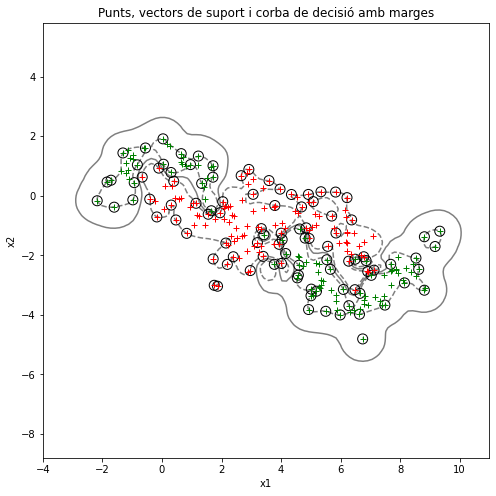

In [39]:
sv=get_sv()

plot_scatter_contour(X_train, y_train, sv, rbf_func, extra_border=1.)

#### Resultat punt 3.c.2

La representació a l'espai original del *mapa de classificació*, és:

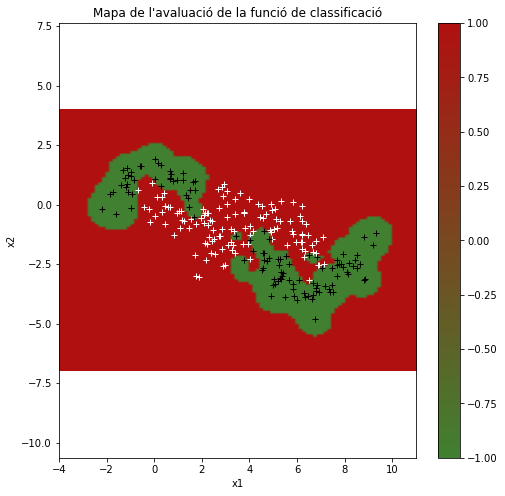

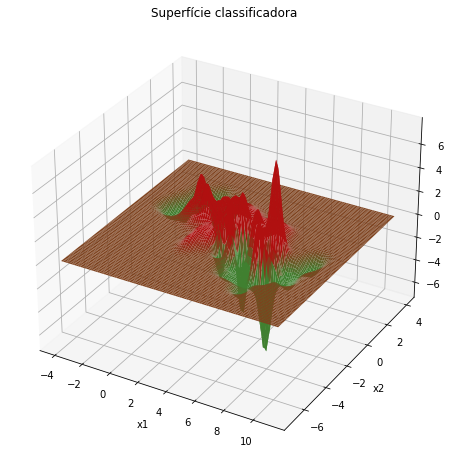

In [43]:
plot_map_plane(X_train, y_train, sv, rbf_func, extra_border=1.)

### Apartat (3.d)

d) Report on the classifier performance using the *test dataset*:
1. measure the *test accuracy*, *test precision*, *test recall* and *test f1-score*; and
2. in a single figure, plot the *test samples* over the already calculated *classification map* (use different markers and/or colours for each class).

### Apartat (3.e)

e) Obtain an improved estimation of the *accuracy*, *precision* and *recall* measures by means of *5-fold cross-validation*. To this end, put together the *training* and *test* datasets, so that the corresponding function can
build the *folds* from all available data.

Performance assessment by cross-validation:

In [ ]:
classification_report(y_test, y_pred)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
clf = clf_.best_estimator_
clfp = make_pipeline(StandardScaler(), clf)
scoring = ['accuracy']
scores = cross_validate(clfp, X, y, cv=5, scoring=scoring)
print('accuracy: ', scores['test_accuracy'])
print('avg acc.: ', np.mean(scores['test_accuracy']))

#### Resultat punt a.2

Ens demanen que cerquem les dues funcions de decisió: 

Espai transformat: $$g_1(x') = w^T x' + w_0' | [x' = \Phi(x)]$$

Espai original: $$g_2(x) = w^T x + w_0$$

Definim una funció genèrica, que ens servirà com a primitiva de les dues que cercam:

In [ ]:
def g_func(x, w: np.ndarray, w0: float) -> np.ndarray:
    
    return np.dot(w.T, x) + w0

I calculam els coeficients i el terme independent per a cada cas:

In [ ]:
w = get_w(lm, y, phi(X))
w

In [ ]:
w0 = get_w0(lm, y, phi(X))
w0

Per tant la funció de decisió a l'espai transformat serà:

In [ ]:
# Funció de decisió  l'espai transformat

def g1(x):
    
    return g_func(x, w, w0)

La provam i aprofitam la nostra funció `epsilize` per arrodonir 
el valor dels punts que cauen a prop del llindar de decisió.
Així és més fàcil confirmar si hi ha vectors de suport degenerats
(vectors en el llindar de decisió 
però que no cal tenir en compte per a la determinació de l'hiperplà):

In [ ]:
def bound(x, eps): 
    return epsilize(epsilize(x, eps, target=1.), eps, target=-1.)

def print_g(g, X, y, eps = 1e-6):
    n_errors = 0
    for i in range(X.shape[0]):
        print(f"g(x{i:2}) = {bound(g(X[i]), eps).item():+.8f}"
              f"  y({i:2}) = {y[i].item():+1}")
        if np.sign(g(X[i]).item()) * y[i].item() == -1:
            n_errors += 1
    print(f"\nErrors de classificació: {n_errors}")
    
    return

# Utilitzam una tolerància de 10^-3 per tal de poder arrodonir 
# el valor de g(x) quan x és un vector de suport
print_g(g1, phi(X), y, 1e-3)

Comprovam que la funció $g_1(x') | [x' = \Phi(x)]$ (espai transformat) està classificant correctament.

> **Nota :** Per tal de visibilitzar els vectors de suport, hem hagut de fer servir la **tolerància 1e-3**,
bastant més elevada que la original 1e-6. 
Suposam que és per mor de la precisió numèrica de *Python*.

Atès que: 

- A l'espai transformat: 

$g_1(x') = w^T x' + w_0 | [x' = \Phi(x)]$

$\Phi(x_1, x_2)=(x_1 x_2, x_1^2 + x_2^2)$

- I a l'espai original:

$g_2(x) = w^T x + w_0$

Podem escriure $g_2(x)$ com:

$g_2((x_1,x_2)) = w_1 x_1 x_2 + w_2 (x_1^2 + x_2^2) + w_0$

Per tant la funció de decisió a l'espai original serà:

In [ ]:
# Funció de decisió a l'espai original

def g2(x):
    
    return (w[0]*x[0]*x[1] + w[1]*(x[0]*x[0]+x[1]*x[1])+w0)

In [ ]:
print_g(g2, X, y)

---

### Apartat (b)

b) Generate the following plots:
1. a first plot with the *training samples* 
in the *transformed space*,
highlighting the *support vectors* 
and plotting the 2D *decision curve*;
2. a second plot with the *training samples* 
in the *original space*,
highlighting the *support vectors* 
and plotting the 2D *decision curve*; and
3. a third plot with the *classification map* **in the *original space***, 
i.e. evaluate the decision function 
for a ’regular’ subset (grid)
of points.

Use different markers and/or colours for each class. See the appendix for examples of the requested plots

### Resposta apartat (b)

Per a fer el diagrames serà pràctic crear una funció 
que ens ajudi a confeccionar les llistes dels components de cada classe:

In [ ]:
cl_w1_index = get_c_index(y, cl_w1_value)

cl_w1_index

In [ ]:
cl_w2_index = get_c_index(y, cl_w2_value)

cl_w2_index

#### Resultat punt b.1

Definim algunes funcions necessàries per a fer els diagrames.

In [ ]:
import numpy as np

def get_view_limits(X: np.ndarray):
    
    ### límits del diagrama:
    x_left = np.floor(np.amin(X, axis = 0)[0] - 0.5)
    x_right = np.ceil(np.amax(X, axis = 0)[0] + 0.5)
    y_top = np.ceil(np.amax(X, axis = 0)[1] + 0.5)
    y_bottom = np.floor(np.amin(X, axis = 0)[1]- 0.5)
    
    return x_left, x_right, y_bottom, y_top


def get_mesh(g_func, 
             x_left: float, x_right: float, y_bottom: float, y_top: float, 
             res: int = 100):

    # calcula malla
    
    xx = np.linspace(x_left, x_right, res)
    yy = np.linspace(y_bottom, y_top, res)
    XX, YY = np.meshgrid(xx, yy, indexing = 'ij')
    Z = np.zeros((res * res, 1))

    k = 0
    for x1 in xx:
        for x2 in yy:
            Z[k] = g_func(np.array((x1, x2), dtype=float))
            k += 1

    return XX, YY, Z

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scatter_contour(X: np.ndarray, y: np.ndarray, sv: list, 
                         g_func, margin_level:float=1.):
    
    # plot samples, highlighting some of them

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_w1_index = get_c_index(y, cl_w1_value)
    cl_w2_index = get_c_index(y, cl_w2_value)

    ## començam a dibuixar
    ##
    plt.figure(1, figsize=(8,8))


    ## dibuixam la corba de decisió i els marges
    ##
    ax = plt.gca()
    ax.contour(XX, YY, Z.reshape(XX.shape), 
               colors='k',
               levels=[-margin_level, 0, margin_level],
               alpha=0.5,linestyles=['--', '-', '--'])

    ## dibuixam els punts per cada classe
    ##
    plt.plot(X[cl_w1_index, 0], X[cl_w1_index, 1], cl_w1_color) # class w1
    plt.plot(X[cl_w2_index, 0], X[cl_w2_index, 1], cl_w2_color) # class w2
    hil = sv # samples to highlight

    ## i remarcam els vectors de suport
    ##
    ax2 = plt.gca()
    ax2.scatter(X[hil, 0], X[hil, 1], s = 100, 
               linewidth = 1, facecolors = 'none', edgecolors = 'k')

    ## format
    ##
    plt.xlim([x_left, x_right])
    plt.ylim([y_bottom, y_top])
    plt.axis('equal')

    ## etiquetam el que manca i llest
    ##
    plt.title('Punts, vectors de suport i corba de decisió amb marges')
    
    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

def plot_map_plane(X: np.ndarray, y: np.ndarray, sv: list, 
                   g_func): 
    
    # matrix-based predicate evaluation

    ## calcula límits cartesians a representar
    ##
    x_left, x_right, y_bottom, y_top = get_view_limits(X)
    
    ## calcula malla de valors de la funció
    ##
    XX, YY, Z = get_mesh(g_func, x_left, x_right, y_bottom, y_top)
    
    ## calcula index de cada classe
    cl_w1_index = get_c_index(y, cl_w1_value)
    cl_w2_index = get_c_index(y, cl_w2_value)

    ## començam a dibuixar
    ##
    plt.figure(1, figsize=(8,8))

    ## cream paleta de colors
    ##
    cl_w1_hex_color = '#b01010'  # red
    cl_w2_hex_color = '#408030'  # green 
    paleta = col.LinearSegmentedColormap.from_list(
        'SVM_2', [cl_w2_hex_color, cl_w1_hex_color])

    ## reduïm a només dues classes
    ##
    C = np.where(Z >= 0, 1, -1)

    ## cream mapa i llegenda
    ##
    plt.imshow(
        C.reshape(XX.shape).T, 
        origin = 'lower', 
        extent = (x_left, x_right, y_bottom, y_top), 
        cmap = paleta)
    plt.colorbar()
    
    ## format
    ##
    plt.title("Mapa de l'avaluació de la funció de classificació")
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    
    plt.axis('equal')
    
    ## mostram
    ##
    plt.show(block=False) # to force visualization

    ## també dibuixarem el plànol en 3D
    ##
    plt.figure(2, figsize=(8,8))
    ax = plt.axes(projection='3d')
    
    ax.plot_surface(XX, YY, Z.reshape(XX.shape), 
                    rstride = 1, cstride = 1, 
                    vmin=-1, vmax=1,
                    cmap = paleta, 
                    edgecolor = 'none')
    
    ## ajustam l'àngle per veure'l millor
    ##
    ax.view_init(45, -60)

    ## etiquetam el que manca i llest
    ##
    plt.title('Hiperplà o superfície classificadora')

    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.show(block = False)
    
    return

#### Representació a l'espai transformat

La representació a l'espai transformat és:

In [ ]:
plot_scatter_contour(phi(X), y, sv_index, g1)

#### Representacions a l'espai original

#### Resultat punt b.2

La representació a l'espai original és:

In [ ]:
plot_scatter_contour(X, y, sv_index, g2)

#### Resultat punt b.3

Anem a fer el tercer diagrama, un mapa de les regions a l'espai original:

In [ ]:
plot_map_plane(X, y, sv_index, g2)

### Apartat (c)

c) Compare the results obtained with the ones resulting from the `scikit-learn SVC` 
object: i.e. report the *support vectors* returned 
by `SVC` and the corresponding *decision function*, 
and provide the same kind of
plots requested before.

> NOTE: the SVC object solves the soft-margin kernel-based 
problem, hence you will have to 
supply the kernel specified in 
a) –use either `kernel = ’precomputed’` and compute the *gram matrix*, 
or supply a *callable* kernel when invoking the `SVC` object constructor– and 
set constant C with a high value, e.g. $10^{16}$, to force a perfect classification of the training set.

In [ ]:
from sklearn import svm

clf = svm.SVC(C = 1e16, kernel = 'precomputed')
clf.fit(build_Gram(phi(X)), y.reshape((N,)))

print(f"Fitted: {clf.fit_status_ == 0}")

Quines posicions ocupen els vectors de suport?

In [ ]:
sk_sv_index = list(clf.support_)
sk_sv_index

L'objecte `SVC`ens ha donat tres vectors de suport 
en lloc dels 4 que havíem trobat resolent el sistema de forma analítica.

Quins són aquests vectors?

In [ ]:
sk_sv = X[sk_sv_index]
sk_sv

I l'intercepto?

In [ ]:
sk_w0 = clf.intercept_.flatten()
sk_w0

I els coeficients $\lambda_i y_i | \lambda_i \ne 0$?

In [ ]:
sk_lamb_y = clf.dual_coef_.flatten()
sk_lamb_y

Per tant la nostra $w$ és:

In [ ]:
sk_w = np.dot(sk_lamb_y, phi(sk_sv)).flatten()
sk_w

Per tant la funció de decisió a l'espai transformat serà:

In [ ]:
def sk_g1(x):
    
    return g_func(x, sk_w, sk_w0)

#### Representació a l'espai transformat

Anem a veure com surten els diagrames:

Espai transformat:

In [ ]:
plot_scatter_contour(phi(X), y, sk_sv_index, sk_g1)

#### Representacions a l'espai original

Espai original:

In [ ]:
def sk_g2(x):
    
    return (sk_w[0]*x[0]*x[1] + sk_w[1]*(x[0]*x[0]+x[1]*x[1])+sk_w0)

In [ ]:
plot_scatter_contour(X, y, sk_sv_index, sk_g2)

In [ ]:
plot_map_plane(X, y, sk_sv_index, sk_g2)

### Apartat (d)

d) Also by means of the `scikit-learn SVC` object, repeat point c) 
for the `’rbf’` kernel ($\gamma = 1$). 
Additionally, draw the corresponding RBF network (slide 43 of the SVM lecture notes), 
replacing $K(x_i, x)$, $\lambda_i$ and $y_i$ by your values.

In [ ]:
from sklearn import svm

clf = svm.SVC(C=1e16, kernel='rbf', gamma=1)
clf.fit(X, y.reshape((N,)))

print(f"Fitted: {clf.fit_status_ == 0}")

Quines posicions ocupen els vectors de suport?

In [ ]:
rbf_sv_index = list(clf.support_)
rbf_sv_index

In [ ]:
y[rbf_sv_index].flatten()

In [ ]:
len(rbf_sv_index)

L'objecte `SVC`ens ha seleccionat tretze vectors de suport 
en lloc dels quatre que havíem trobat resolent el sistema de forma analítica.

Quins són aquests vectors?

In [ ]:
X[rbf_sv_index]

I l'intercepto?

In [ ]:
rbf_w0 = clf.intercept_.flatten()
rbf_w0

I els coeficients $\lambda_i y_i | \lambda_i \ne 0$?

In [ ]:
rbf_lamb_y = clf.dual_coef_.flatten()
rbf_lamb_y

#### Representació a l'espai transformat

En el cas del kernel RBF, la funció de decisió a l'espai transformat 

$g_1(x') = w^T x' + w_0 | [x' = \Phi(x)]$

no té una expressió tancada, 
doncs l'expansió de la funció del kernel genera un espai infinit.

Per tant no podrem representar la funció de decisió a l'espai transformat.

#### Representacions a l'espai original

Atès que feim servir el kernel Radial Basis Function ...

$K(x_i,x) = e^{-\gamma||x_i - x||^2}$ amb $\gamma = 1$

... la nostra particular funció de kernel serà: 

$K(x_i,x) |_{\gamma = 1} = e^{-||x_i - x||^2}$

Per tant la funció de decisió a l'espai original serà:

$g_2(x) = \sum_{i|\lambda_i \ne 0} \lambda_i y_i K(x_i,x)|_{\gamma = 1} + w_0$

Definim la funció de kernel RBF i la funció de decisió a l'espai original:

In [ ]:
import numpy as np

def rbf(x: np.ndarray, z: np.ndarray, gamma: float = 1.) -> float:
    
    return np.exp(-gamma * (np.dot(x - z, (x - z).T)))

In [ ]:
def rbf_g2(x) -> float:
    
    r = rbf_w0.item()
    for i in range(len(rbf_sv_index)):
        r += rbf(x, X[rbf_sv_index[i]]) * rbf_lamb_y[i]
    
    return r

In [ ]:
plot_scatter_contour(X, y, rbf_sv_index, rbf_g2)

In [ ]:
plot_map_plane(X, y, rbf_sv_index, rbf_g2)

- El conjunt de vectors de suport és:

In [ ]:
for i in range(len(rbf_sv_index)):
    print(f"x_{rbf_sv_index[i]:02} = ({X[rbf_sv_index[i]][0]:+.2f}, {X[rbf_sv_index[i]][1]:+.2f})")

- El conjunt de coeficients $\lambda_i y_i$ és:

In [ ]:
for i in range(len(rbf_sv_index)):
    print(f"lambda_{rbf_sv_index[i]:02} * y_{rbf_sv_index[i]:02} = {rbf_lamb_y[i]:+.2f}")

I per acabar, l'intercepto val:

In [ ]:
print(f"w0 = {rbf_w0.item():+.2f}")

## Problem 4

**Given datasets** `dsxx34tr.txt` **and** `dsxx34te.txt`, 
find a suitable k-NN classifier 
(`KNeighborsClassifier` object of `scikit-learn`).
You have to define the classifier design strategy, 
including data normalization, e.g. *min-max* scaling,
and setting up the classifier hyper-parameters, 
e.g. by means of *grid-search*, 
as well as estimate the classifier 
performance by means of *n-fold cross validation*.

### Apartat (4.a)

a) Define the design strategy: input data normalization, 
combinations of hyper-parameters considered 
(number of neighbours and distance function), 
number of folds for the cross-validation process.

### Apartat (4.b)

b) Using the *training dataset*, find the best performing classifier according to the design strategy and employing the accuracy as erformance metric for the cross-validation process.

### Apartat (4.c)

c) Plot the training samples on top of the *classification map*, i.e. evaluate the decision function for a 'regular' subset (grid) of points of the feature space. 
Use different markers and/or colours for each class.

### Apartat (4.d)

d) Report on the classifier performance using the *test dataset*:
1. measure the *test accuracy*, *test precision*, *test recall* and *test f1-score*; and
2. in a single figure, plot the *test samples* over the already calculated *classification map* (use different markers and/or colours for each class).

### Apartat (4.e)

e) Obtain an improved estimation of the *accuracy*, *precision* and *recall* measures by means of *5-fold cross-validation*. To this end, put together the *training* and *test* datasets, so that the corresponding function can
build the *folds* from all available data.

## Conclusions

En aquest problema hem determinat
els vectors de suport d'un problema no linealment separable, 
fent servir dos espais alternatius distints.

Hem resolt el primer espai, determinat per la funció 
transformadora $\Phi(x_1, x_2) = (x_1 x_2, x_1^2 + x_2^2)$, 
per dos mètodes distints: 

1. per via analítica, fent servir la funció solve_qp per a resoldre el sistema plantejat
2. fent servir la classe `SVC` de la llibreria `svm` del paquet `sklearn`.

En el primer cas hem trobat 4 vectors de suport (3 d'ells, de la classe $y=-1$). 

El segon mètode ha donat com a resultat un conjunt de 3 vectors de suport, 
(2 d'ells de la classe $y=-1$). 
Aquest segon conjunt de vectors de suport ha resultat ser 
un subconjunt del primer (obtingut via analítica). 
L'únic vector que no ha aparegut 
a aquesta segona solució era el vector que tenia 
un coeficient $\lambda$ de l'ordre del $10^{-5}$ a la solució analítica.

En ambdós casos, com era previsible, 
la representació gràfica ha estat molt similar. 
I les superfícies 3d generades per ambdues funcions classificadores 
són de tipus quasi-parabolòide.

Pel que fa a la solució cercada dins l'espai que genera el kernel RBF, 
hem obtingut un total de 13 vectors de suport. 
En aquest cas es pot apreciar que en el diagrama a on es representa 
la seva funció de classificació, la corba està més ajustada als 
vectors de suport que a les dues solucions anteriors, en concret 
el marge de la classe $y=-1$ toca 10 vectors. 
Els altres 3 vectors de suport marquen la classe $y=+1$.
És evident per tant, que aplicant la RBF (considerant $\gamma = 1$) 
obtenim una funció de classificació més dolça i més ajustada 
(la qual cosa també té el perill de fer patir d'éxcés d'ajust 
i aleshores de manca de generalització).

Sabent que la funció kernel es pot entendre com una funció de semblança, 
que dona valors alts (en el cas RBF, propers a 1) si els dos vectors 
són propers i valors baixos (propers a zero) si els vectors estan allunyats, 
es pot comprendre millor la relació que hi ha entre 
l'aspecte de la superfície de classificació i l'esquema de la xarxa 
neuronal representats: 

- tots el coeficients $\lambda_i$ que formen part de la solució, són estrictament positius;
- per tant el resultat de totes les funcions de kernel amb un argument $x_i$ 
tal que $x_i$ pertany a la classe $y_i=-1$, estan multiplicats per un 
coeficient negatiu ($\lambda_i \cdot y_i$);
- el resultat de totes les funcions de kernel amb un argument $x_i$ 
tal que $x_i$ pertany a la classe $y_i=+1$, estan multiplicats per un 
coeficient positiu ($\lambda_i \cdot y_i$);
- si el vector a classificar, 
$x$ és proper a un vector de suport $x_i$ 
de classe $y_i=-1$, la funció $K(x_i,x)$ donarà un valor alt, 
com que està multiplicat per un coeficient negatiu, 
contribuirà a baixar el resultat de la funció de classificació, 
l'aportació dels altres termes del sumatori serà petita 
perquè el vector a classificar estarà a major distància dels seus respectius vectors de suport;
- si el vector a classificar, 
$x$ és proper a un vector de suport $x_i$ 
de classe $y_i=+1$, la funció $K(x_i,x)$ donarà un valor alt, 
com que està multiplicat per un coeficient positiu, 
contribuirà a pujar el resultat de la funció de classificació, 
l'aportació dels altres termes del sumatori serà petita 
perquè el vector a classificar estarà a major distància dels seus respectius vectors de suport;
- el paràmetre $\gamma$ modula l'amplària de la funció $K_{RBF}(x, z)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f_rbf(d, g):
    return np.exp(-g * d * d)

g = np.array([0.5, 1, 2, 10], dtype=float)
x = np.arange(-3.0, 3.0, 0.1)
c = ['r--', 'g', 'b--', 'purple']
lines = []

plt.figure(1)

ax = plt.axes()

for i in range(len(c)):
    line, = ax.plot(x, f_rbf(x, g[i]), c[i % len(c)], label=f"$\gamma$={g[i]}")
    lines.append(line)
    
ax.legend(handles=lines)

plt.title('RBF per a diferents valors del discriminador $\gamma$')

plt.show()

Com es pot veure a la representació anterior, 
com més gran és el valor de $\gamma$, 
més estreta és la regió de semblança 
i per tant la regió d'influència de cada vector de suport 
és menor, el què afavoreix que el model necessiti més 
vectors de suport per a construir el model. 
Això augmenta el risc de patir sobreajustament.

Per tal de trobar el valor de $\gamma$ que generi la 
millor xarxa RBF classificadora, cal fer una cerca d'aquest valor, 
provant-ne un conjunt i avaluant per a cada un, 
les mètriques de la xarxa en validació.

**The End**